<a href="https://colab.research.google.com/github/sh3986/kaggle/blob/main/project3/main_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day2
## Speech Command Recognition baseline with Torch


패키지 설치

In [1]:
!pip install torchaudio torchinfo
!pip install einops
# !pip install pyroomacoustics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Library Import

In [2]:
import torch
import torch.fft
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torchinfo import summary

from torch.utils.data import Dataset, IterableDataset
from torch.utils.data.dataloader import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS

import numpy as np
import scipy
from scipy import signal

import soundfile as sf

import librosa
import librosa.display

import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd

# import pyroomacoustics as pra

from einops import rearrange

import io
import os
import math
import glob
from tqdm import tqdm
from collections import OrderedDict


### Wave Analysis Function

In [3]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):

  if isinstance(waveform, np.ndarray):
    pass
  else:
    waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = np.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)
  
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  
  if isinstance(waveform, np.ndarray):
    pass
  else:
    waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = np.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  if isinstance(waveform, np.ndarray):
    pass
  else:
    waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(spec, origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


GPU 동작 확인

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Public dataset 경로 \
https://drive.google.com/drive/folders/1CJuVPfiYsI4v1BK-SakT7frf8Nv-p-bn

In [6]:
# !ls drive/MyDrive/public_set

In [7]:
# !ls drive/MyDrive/public_set/npy

### Train / Valid set Download

In [8]:
train_set = torchaudio.datasets.SPEECHCOMMANDS(root = '', download = True, subset = "training")
valid_set = torchaudio.datasets.SPEECHCOMMANDS(root = '', download = True, subset = "validation")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
print(train_set[0])

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

(tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]]), 16000, 'backward', '0165e0e8', 0)


In [9]:
labels = sorted(list(set(datapoint[2] for datapoint in valid_set)))

def label_to_index(word):
    return torch.tensor(labels.index(word))
    
print(' '.join(['{} {}'.format(label_to_index(label), label) for label in labels]))

0 backward 1 bed 2 bird 3 cat 4 dog 5 down 6 eight 7 five 8 follow 9 forward 10 four 11 go 12 happy 13 house 14 learn 15 left 16 marvin 17 nine 18 no 19 off 20 on 21 one 22 right 23 seven 24 sheila 25 six 26 stop 27 three 28 tree 29 two 30 up 31 visual 32 wow 33 yes 34 zero


### Background Noise

In [74]:
noise_data_dir = '/content/drive/MyDrive/Colab Notebooks/Kaggle/project_3_signal/data/noises'
noise_file_list = os.listdir(noise_data_dir)
noise_file_list = [os.path.join(noise_data_dir, x) for x in noise_file_list]
noise_file_list

['/content/drive/MyDrive/Colab Notebooks/Kaggle/project_3_signal/data/noises/doing_the_dishes.wav',
 '/content/drive/MyDrive/Colab Notebooks/Kaggle/project_3_signal/data/noises/dude_miaowing.wav',
 '/content/drive/MyDrive/Colab Notebooks/Kaggle/project_3_signal/data/noises/white_noise.wav',
 '/content/drive/MyDrive/Colab Notebooks/Kaggle/project_3_signal/data/noises/running_tap.wav',
 '/content/drive/MyDrive/Colab Notebooks/Kaggle/project_3_signal/data/noises/pink_noise.wav',
 '/content/drive/MyDrive/Colab Notebooks/Kaggle/project_3_signal/data/noises/exercise_bike.wav']

In [166]:
class NoiseTransformer:
    def __init__(self, file_list):
        self.data_set = dict()
        self.sample_rate = None
        for path in file_list:
            noise, sample_rate = torchaudio.load(path)
            self.data_set[path.split('/')[-1]] = [noise, sample_rate]
        self.snr_db_list = [15, 5, 0, -5]
        # self.snr_db_list = [10]

    def __len__(self):
        return len(self.data_set)

    def transform(self, input, idx=None):
        audio = torch.Tensor(input)

        noise_list = list(self.data_set.keys())
        if idx is None:
            idx = np.random.randint(len(noise_list))
            
        snr_db = np.random.choice(self.snr_db_list, 1)[0]
        noise = self.data_set[noise_list[idx]][0]
        sample_rate = self.data_set[noise_list[idx]][1]

        if sample_rate != 16000:
            transform = torchaudio.transforms.Resample(sample_rate,16000)
            noise = transform(noise)
            sample_rate = 16000
        
        if noise.shape[0] != 1:
            return audio.numpy()
            noise = noise[0].expand(1, -1)

        noise = noise[:, 5*sample_rate:5*sample_rate + audio.shape[1]]
        if noise.shape[1] != 16000:
            return audio.numpy()
        noise_power = noise.norm(p=2)
       
        audio_power = audio.norm(p=2)

        snr = 10 ** (snr_db / 10)
        scale = snr * noise_power / audio_power
        noise_audio = (scale * audio + noise) / 2

        return noise_audio.numpy()

### Torch Dataset

In [167]:
class TrainDataset(Dataset):
    def __init__(self, dataset, transformer = None):
        super().__init__()
        self.command_dataset = dataset
        self.transformer = transformer

    def __getitem__(self, idx):
        raw_wav = self.command_dataset[idx][0][0]
        raw_wav_pad = np.pad(raw_wav, (0, 16000 - raw_wav.shape[-1]))

        audio = np.expand_dims(raw_wav_pad, 0)
        if (self.transformer is not None) and (np.random.random() > 0.3):
            audio = self.transformer.transform(audio)

        # white_g_noise = np.random.normal(0, 0.01, audio.shape[1])
        # audio = audio + white_g_noise
        # audio = audio.astype(np.float32)

        label_word = self.command_dataset[idx][2]
        label_index = label_to_index(label_word)

        return audio, label_index

    def __len__(self):
        # return self.expand_size
        return len(self.command_dataset)

class ValidDataSet(Dataset):
    def __init__(self, dataset, transformer = None):
        super().__init__()
        self.command_dataset = dataset
        self.transformer = transformer

    def __getitem__(self, idx):
        raw_wav = self.command_dataset[idx][0][0]
        raw_wav_pad = np.pad(raw_wav, (0, 16000 - raw_wav.shape[-1]))
        
        audio = np.expand_dims(raw_wav_pad, 0)
        if (self.transformer is not None) and (np.random.random() > 0.3):
            audio = self.transformer.transform(audio)
            
        label_word = self.command_dataset[idx][2]
        label_index = label_to_index(label_word)

        return audio, label_index

    def __len__(self):
        return len(self.command_dataset)

In [168]:
noise_transformer = NoiseTransformer(noise_file_list)
train_set_custom = TrainDataset(train_set, noise_transformer)
valid_set_custom = ValidDataSet(valid_set)

In [92]:
print("Noise File Count : ", len(noise_transformer))

Noise File Count :  6


### Audio 확인

In [67]:
for key, value in noise_transformer.data_set.items():
    print(key, value[0].shape)

white_noise.wav torch.Size([1, 960000])
doing_the_dishes.wav torch.Size([1, 1522930])
running_tap.wav torch.Size([1, 978488])
dude_miaowing.wav torch.Size([1, 988891])
pink_noise.wav torch.Size([1, 960000])
exercise_bike.wav torch.Size([1, 980062])
audiocheck_brownnoise.wav torch.Size([1, 441001])
audiocheck_bluenoise.wav torch.Size([1, 441001])
audiocheck_violetnoise.wav torch.Size([1, 441001])
audiocheck_gray_noise.wav torch.Size([1, 2646000])
audiocheck_train_passby.wav torch.Size([2, 624000])
footsteps_grass.wav torch.Size([2, 1018839])
keyboard_typing.wav torch.Size([2, 1160406])
light_rain.wav torch.Size([2, 661500])
cinematic_tunnel_reverb.wav torch.Size([2, 297542])
dial_phone_tone.wav torch.Size([2, 683906])
electricity_buzz.wav torch.Size([2, 544415])
train_arrival.wav torch.Size([2, 890578])
hostital_machine_beep.wav torch.Size([2, 264600])
loud_children.wav torch.Size([2, 1561691])
people_laughter.wav torch.Size([2, 662029])
street_carriage_people.wav torch.Size([2, 457707]

In [68]:
file_name = 'dude_miaowing.wav'
noise = noise_transformer.data_set[file_name][0]
if sample_rate != 16000:
    transform = torchaudio.transforms.Resample(sample_rate,16000)
    noise = transform(noise)
    sample_rate = 16000

if noise.shape[0] != 1:
    noise = noise[0].expand(1, -1)
# noise = noise[:, 5*sample_rate:5*sample_rate + audio.shape[1]]
sample_rate = noise_transformer.data_set[file_name][1]
ipd.Audio(noise, rate=sample_rate)

In [25]:
file_name = 'metal_bowl_hit.wav'
noise = noise_transformer.data_set[file_name][0]
sample_rate = noise_transformer.data_set[file_name][1]
if sample_rate != 16000:
    transform = torchaudio.transforms.Resample(sample_rate,16000)
    noise = transform(noise)
    sample_rate = 16000

if noise.shape[0] != 1:
    noise = noise[0].expand(1, -1)

print(noise.shape)
ipd.Audio(noise, rate=sample_rate)

torch.Size([1, 33313])


In [35]:
#  확인용
data = train_set_custom[7203]
print('label : ', data[1])
ipd.Audio(data[0], rate=16000)
sample_rate = 16000

label :  tensor(4)


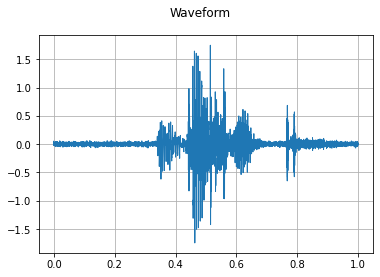

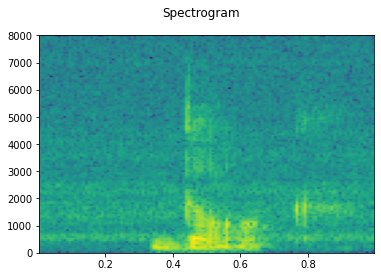

In [ ]:
plot_waveform(data[0], sample_rate)
plot_specgram(data[0], sample_rate)

In [ ]:
white_g_noise = np.random.normal(0, 0.01, data[0].shape[1])
white_g_noise = np.expand_dims(white_g_noise, 0)

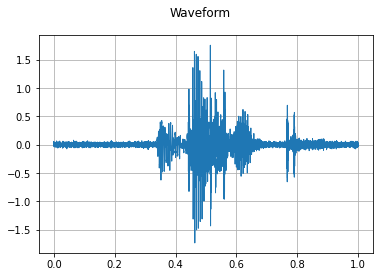

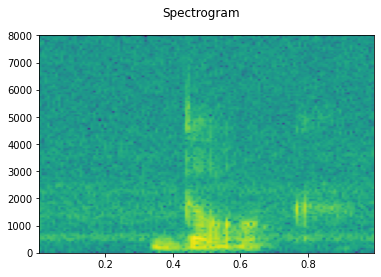

In [ ]:
plot_waveform(data[0]+white_g_noise, sample_rate)
plot_specgram(data[0]+white_g_noise, sample_rate)

In [ ]:
ipd.Audio(data[0]+white_g_noise, rate=16000)

In [ ]:
ipd.Audio(noise_transformer.transform(data[0]), rate=16000)

### Data Loader

In [169]:
batch_size = 32
train_loader = DataLoader(train_set_custom, 
                          batch_size = batch_size, 
                          shuffle = True, 
                          pin_memory = True, 
                          num_workers = 2, 
                          worker_init_fn = lambda _: np.random.seed())

valid_loader = DataLoader(valid_set_custom, 
                          batch_size = batch_size, 
                          shuffle = False, 
                          pin_memory = True, 
                          num_workers = 2, 
                          worker_init_fn = lambda _: np.random.seed())

### AutoEncoder

In [120]:
class ConvBlock2D(nn.Module):
    def __init__(self, c_i, c_o, k = 3, s = 1, pool_k = 2):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c_i, c_o, k, s),
            nn.BatchNorm2d(c_o),
            nn.ReLU(),
            nn.MaxPool2d(pool_k)
        )
    def forward(self, x):
        return self.block(x)
        
class ConvTransposeBlock2D(nn.Module):
    def __init__(self, c_i, c_o, k = 3, s = 1, pool_k = 2):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(c_i, c_o, k, s),
            nn.BatchNorm2d(c_o),
            nn.ReLU(),
            nn.MaxPool2d(pool_k)
        )
    def forward(self, x):
        return self.block(x)


In [136]:
class Enocder(nn.Module):
    def __init__(self, c_in, c_hidden):
        super().__init__()
        self.spec = torchaudio.transforms.MelSpectrogram(sample_rate = 16000, n_fft = 1024, hop_length=256, n_mels = 128)
        self.layer = nn.Sequential(
            ConvBlock2D(c_in, c_hidden),
            ConvBlock2D(c_hidden, c_hidden),
            ConvBlock2D(c_hidden, 2 * c_hidden),
            ConvBlock2D(2 * c_hidden, 2 *c_hidden)
        )

    def forward(self, x):
        x = torch.log10(self.spec(x) + 1e-5) 
        out = self.layer(x)
        out = out.view(batch_size, -1)
        # out = rearrange(F.avg_pool2d(out, out.shape[-2:]), 'b c 1 1 -> b c') 
        return out

In [245]:
class Decoder(nn.Module):
    def __init__(self, c_in, c_hidden, c_out):
        super().__init__()
        self.layer = nn.Sequential(
            ConvTransposeBlock2D(c_in, c_hidden),
            ConvTransposeBlock2D(c_hidden, c_hidden//2),
            ConvTransposeBlock2D(c_hidden//2, c_hidden//2),
            ConvTransposeBlock2D(c_hidden//2, c_out)
        )

    def forward(self, x):
        out = x.view(batch_size, 256, 6, 2)
        out = self.layer(out) # torch.Size([32, 16000, 2, 2])
        out = rearrange(F.avg_pool2d(out, out.shape[-2:]), 'b c 1 1 -> b c') # torch.Size([32, 16000]) 
        out = torch.reshape(out, (out.shape[0], -1, out.shape[1])) # torch.Size([32, 1, 16000])
        return out

In [246]:
class AutoEncoder:
    def __init__(self, encoder, decoder):
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.parameters  = list(encoder.parameters())+ list(decoder.parameters())

    def train(self, train_loader, ep, opt, lossmod):
        self.encoder.train()
        self.decoder.train()

        losses = []
        for batch_idx, (wav, label) in enumerate(tqdm(train_loader, position = 0)):
            wav, label = wav.to(device), label.to(device)

            output = self.encoder(wav)
            output = self.decoder(output)

            loss = lossmod(wav, output)
            opt.zero_grad()
            loss.backward()
            opt.step()

            losses.append(loss.item())
    
    
    def valid(self, valid_loader, ep,):
        self.encoder.eval()
        self.decoder.eval()

        correct = 0
        losses = []
        for data, target in tqdm(valid_loader, position = 0):
            data = data.to(device)
            target = target.to(device)

            output = self.encoder(data)
            output = self.decoder(output)

            pred = get_likely_index(output)
            correct += number_of_correct(pred, target)
        
        print("Valid epoch: {}, acc: {:.4f}".format(ep, correct / len(valid_set)))

### Model 정의 : 2D CNN

In [94]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor): 
    return tensor.argmax(dim=-1)
    
def train(model, ep, opt, lossmod):
    model.train()
    losses = []
    for batch_idx, (wav, label) in enumerate(tqdm(train_loader, position = 0)):
        wav, label = wav.to(device), label.to(device)

        z = model(wav)
        loss = lossmod(z, label)
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
    print('Epoch: {} Loss: {:.4f}'.format(ep, np.average(losses)))

def validation(model, ep):
    model.eval()
    correct = 0
    losses = []
    for data, target in tqdm(valid_loader, position = 0):
        data = data.to(device)
        target = target.to(device)

        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)
    
    print("Valid epoch: {}, acc: {:.4f}".format(ep, correct / len(valid_set)))

In [95]:
class ConvBlock2D(nn.Module):
    def __init__(self, c_i, c_o, k = 3, s = 1, pool_k = 2):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(c_i, c_o, k, s),
                                   nn.BatchNorm2d(c_o),
                                   nn.ReLU(),
                                   nn.MaxPool2d(pool_k))
    def forward(self, x):
        return self.block(x)

class CNN2D(nn.Module):
    def __init__(self, c_in, c, num_classes):
        super().__init__()
        self.spec = torchaudio.transforms.MelSpectrogram(sample_rate = 16000, n_fft = 1024, hop_length=256, n_mels = 128)
        self.convnet = nn.Sequential(ConvBlock2D(c_in, c),
                                     ConvBlock2D(c, c),
                                     ConvBlock2D(c, 2 * c),
                                     ConvBlock2D(2 * c, 2 * c))
        self.linear = nn.Linear(2 * c, num_classes)
    
    def forward(self, x):
        x = torch.log10(self.spec(x) + 1e-5) # log-mel spectrogram: 1D audio -> 2D image-like representation
        z = self.convnet(x) # log-mel spec -> 2D CNN -> feature map C x F x T 
        z = rearrange(F.avg_pool2d(z, z.shape[-2:]), 'b c 1 1 -> b c') # feature map C x F x T -> feature C x 1 x 1
        z = self.linear(z) # feature C -> logit N
        return z

### Training : 2D CNN

In [247]:
encoder = Enocder(c_in = 1, c_hidden = 128)
decoder = Decoder(c_in = 256, c_hidden = 128, c_out=sample_rate)

In [248]:
auto_encoder = AutoEncoder(encoder, decoder)

In [192]:
# n_epoch = 10
# opt = torch.optim.Adam(auto_encoder.parameters, lr = 1e-3)
# loss_func = nn.MSELoss()
# self = auto_encoder
# ep = 0

# self.encoder.train()
# self.decoder.train()

# losses = []
# for batch_idx, (wav, label) in enumerate(tqdm(train_loader, position = 0)):
#     wav, label = wav.to(device), label.to(device)
#     wav.shape
#     break
# output = self.encoder(wav)
# output.shape

# decoder = Decoder(c_in = 256, c_hidden = 128, c_out=sample_rate).to(device)
# output2 = decoder(output)

In [ ]:
n_epoch = 10
opt = torch.optim.Adam(auto_encoder.parameters, lr = 1e-3)
loss_func = nn.MSELoss()

for epoch in range(1, n_epoch + 1):
    auto_encoder.train(train_loader, epoch, opt, loss_func)
    break

 33%|███▎      | 865/2652 [00:30<01:02, 28.58it/s]

In [96]:
net = CNN2D(c_in = 1, c = 128, num_classes = len(labels)).to(device)
summary(net, (1, 1, 16000))

Layer (type:depth-idx)                   Output Shape              Param #
CNN2D                                    [1, 35]                   --
├─MelSpectrogram: 1-1                    [1, 1, 128, 63]           --
│    └─Spectrogram: 2-1                  [1, 1, 513, 63]           --
│    └─MelScale: 2-2                     [1, 1, 128, 63]           --
├─Sequential: 1-2                        [1, 256, 6, 2]            --
│    └─ConvBlock2D: 2-3                  [1, 128, 63, 30]          --
│    │    └─Sequential: 3-1              [1, 128, 63, 30]          1,536
│    └─ConvBlock2D: 2-4                  [1, 128, 30, 14]          --
│    │    └─Sequential: 3-2              [1, 128, 30, 14]          147,840
│    └─ConvBlock2D: 2-5                  [1, 256, 14, 6]           --
│    │    └─Sequential: 3-3              [1, 256, 14, 6]           295,680
│    └─ConvBlock2D: 2-6                  [1, 256, 6, 2]            --
│    │    └─Sequential: 3-4              [1, 256, 6, 2]            590,5

In [97]:
n_epoch = 10
opt = torch.optim.Adam(net.parameters(), lr = 1e-3)
ce = nn.CrossEntropyLoss()
for epoch in range(1, n_epoch + 1):
    train(net, epoch, opt, ce)
    validation(net, epoch)

  0%|          | 0/2652 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/Kaggle/project_3_signal/model/noise_snr_10_rate70_wgn.h5'
torch.save(net.state_dict(), model_path)

### 모델 Evaluation

In [ ]:
net = CNN2D(c_in = 1, c = 128, num_classes = len(labels)).to(device)
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
public_testset_dir = '/content/drive/MyDrive/Colab Notebooks/Kaggle/project_3_signal/data/public_set/npy'

In [ ]:
for folder in ['0','1','2']:
    print('folder : ', folder)
    wav_npy_list = glob.glob(os.path.join(public_testset_dir, folder, '*.npy'))
    wav_npy_list.sort()
    wav_npy_list = wav_npy_list[:-1]

    ans_npy = np.load(os.path.join(public_testset_dir, folder, 'ans.npy'))
    with torch.no_grad():
        correct = 0
        net.eval()
        preds = []
        for i, wav_npy_dir in enumerate(tqdm(wav_npy_list, position = 0, leave = True)):
            wav_npy = np.load(wav_npy_dir)
            wav_npy = torch.tensor(np.reshape(wav_npy, (1, 1, wav_npy.shape[0]))).to(device)
            ans = torch.tensor(ans_npy).to(device)
            
            output = net(wav_npy)

            pred = get_likely_index(output)
            correct += number_of_correct(pred, ans[i])        

            preds.append(pred.detach().cpu().numpy()[0])
        print("\nAcc: {:.4f}\n".format(correct / len(wav_npy_list)))

folder :  0


100%|██████████| 88/88 [00:00<00:00, 306.78it/s]



Acc: 0.8409

folder :  1


100%|██████████| 51/51 [00:00<00:00, 289.03it/s]



Acc: 0.6078

folder :  2


100%|██████████| 61/61 [00:00<00:00, 301.00it/s]


Acc: 0.3770



In [ ]:
pred.detach().cpu().numpy()[0]

26

Save predict.npy \
data shape을 꼭 확인하세요!

In [ ]:
# np.save('predict.npy', np.asarray(preds))

### 참고

```python
# 저장하기:
torch.save(model.state_dict(), PATH)

# 불러오기:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
```

In [ ]:
# data_dir = 'drive/MyDrive/tutorial_1_samples'
# noise_data_dir = 'drive/MyDrive/tutorial_1_noises'
# speech, sample_rate = torchaudio.load(os.path.join(data_dir, 'yes_male.wav'))
# noise, sample_rate = torchaudio.load(os.path.join(noise_data_dir, 'exercise_bike.wav'))

# noise = noise[:, 5*sample_rate:5*sample_rate + speech.shape[1]]

# plot_waveform(speech, sample_rate, title="Speech")
# plot_specgram(speech, sample_rate, title="Speech")
# plot_waveform(noise, sample_rate, title="Background noise")
# plot_specgram(noise, sample_rate, title="Background noise")
# play_audio(noise, sample_rate)

# speech_power = speech.norm(p=2)
# noise_power = noise.norm(p=2)

# for snr_db in [20, 3, -6]:
#   snr = 10 ** (snr_db / 10)
#   scale = snr * noise_power / speech_power
#   noisy_speech = (scale * speech + noise) / 2

#   plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
#   plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
#   play_audio(noisy_speech, sample_rate)

In [ ]:
from torch.utils.data import IterableDataset

class MyIterableDataset(IterableDataset):

    def __init__(self, data_path):
        self.data_path = data_path

    def __iter__(self):
        iter_csv = pd.read_csv(self.data_path, sep='\t', iterator=True, chunksize=1)
        for line in iter_csv:
            line = line['text'].item()
            yield line

loader = DataLoader(map_dataset, batch_size=4, num_workers=0)
for d in loader:
    batch, worker_ids, starts, ends = d
    print(batch, worker_ids)

In [ ]:
class NoiseIterableDataset(IterableDataset):
    def __init__(self, dataset, noise_set):
        super().__init__()
        self.command_dataset = dataset

    def __getitem__(self, idx):
        raw_wav = self.command_dataset[idx][0][0]
        raw_wav_pad = np.pad(raw_wav, (0, 16000 - raw_wav.shape[-1]))

        label_word = self.command_dataset[idx][2]
        label_index = label_to_index(label_word)

        return np.expand_dims(raw_wav_pad, 0), label_index

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # 단일 프로세스 데이터로드, 전체 반복자 반환
            worker_id = self.rank * worker_info.num_workers + worker_info.id
            total_workers = self.world_size * worker_info.num_workers
        else:
            worker_id = worker_info.id
            total_workers = self.dataloader_workers
       
        for idx in idx_list:
            audio, label_index = self[idx]
            yield audio, label_index

            for noise_idx in range(len(noise_set)):
                noise_audio = noise_set.add_noise(audio, noise_idx)
                yield noise_audio, label_index

    def __len__(self):
        return len(self.command_dataset)

# train_set_noise = NoiseIterableDataset(train_set, noise_set)